## Obtain spectra for the sources and add additional spec-zs from SIMBAD

In [231]:
%matplotlib inline
import sys, os, glob, copy

from astropy.io import fits, ascii

import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
import astropy.constants as const
from astropy.coordinates import SkyCoord, concatenate
from astropy import table
import scienceplots

plt.style.use(['bright', 'science', 'no-latex', 'notebook'])

### Read the HSC-SSP AGN table:

https://ui.adsabs.harvard.edu/abs/2020ApJ...894...24K/abstract

In [232]:
# Read HSC-SSP AGNs
data_agn = ascii.read('hsc_agn.txt')
cat_agn = SkyCoord(data_agn['RAdeg'], data_agn['DEdeg'], unit='deg')
data_agn

ID,RAdeg,DEdeg,i-mag,X-flag,g-flag,r-flag,i-flag,z-flag,n-corr,z,r_z,ID-COSMOS2015
--,deg,deg,mag,--,--,--,--,--,--,--,--,--
int64,float64,float64,float64,int64,int64,int64,int64,int64,int64,float64,int64,int64
1,150.74386,2.20245,22.71,1,1,1,1,1,6,1.561,3,594392
2,150.73557,2.19957,20.36,1,1,1,1,1,6,3.499,1,592797
3,150.73353,2.15646,20.88,1,1,1,1,1,6,0.977,1,565402
4,150.79702,2.13888,21.01,1,1,1,1,1,6,0.573,1,552225
5,150.78259,2.19306,20.63,1,1,1,1,1,6,0.585,1,589540
6,150.72019,2.24803,21.13,1,1,1,1,1,6,0.664,1,625595
7,150.78838,2.34399,19.82,1,1,1,1,1,6,1.964,1,689768
8,150.71511,2.48483,19.2,1,1,1,1,1,6,1.999,1,782508


1: spectroscopic redshift from the HSC catalog,

2: spectroscopic redshift from the DEIMOS catalog,

3: photometric redshift from z_best in the Chandra catalog,

4: photometric redshift from ZPDF in the COSMOS2015 catalog.

There are still more with spectra than it appears this table!

### Update to HSC PDR3 spectra

data release: https://hsc-release.mtk.nao.ac.jp/doc/index.php/data-access__pdr3/

inquiry website: https://hsc-release.mtk.nao.ac.jp/datasearch/

keyword description: https://hsc-release.mtk.nao.ac.jp/schema/#pdr3.pdr3_dud_rev.specz 

source description: https://hsc-release.mtk.nao.ac.jp/doc/index.php/catalog-of-spectroscopic-redshifts__pdr3/

#### Grab the HSC data and see what database it comes from

We first download all the spectra in cosmos field and then filter them using python. HSC catalog uses `SQL` to inquire about the redshift, which is not suitable for mass and fuzzy inquiry. 

```sql

SELECT
    object_id
      , specz_ra
      , specz_dec
      , specz_redshift
      , specz_duplicationflag

      , specz_flag_zcosmos_bright_dr3
      , specz_flag_3dhst_v4_1_5
      , specz_flag_sdss_dr15
      , specz_flag_gama_dr3
      , specz_flag_udsz_dr1
      , specz_flag_vandels_dr2
      , specz_flag_c3r2_dr2
      , specz_flag_vvds_drfinal
      , specz_flag_deimos_2018
      , specz_flag_fmos_dr2
      , specz_flag_lega_c_dr2
      , specz_flag_primus_dr1
      , specz_flag_vipers_dr2
      , specz_flag_wigglez_dr1
      , specz_flag_deep23_dr4_egs

    FROM pdr3_dud_rev.specz
    WHERE
        specz_ra BETWEEN 149.4 AND 150.9
        AND specz_dec BETWEEN 1.6 AND 2.8
    -- ORDER BY specz_ra LIMIT 10
;

```

It will return a `csv` file that contains all the spec-z in COSMOS field. I have renamed it to `hsc-spec-cosmos.txt`

In [233]:
mask_specz = data_agn['r_z'] < 3

data_coords = SkyCoord(data_agn['RAdeg'], data_agn['DEdeg'], unit=u.deg)
print(len(data_coords))
print(len(data_coords[mask_specz]))

source_keys = ['specz_flag_zcosmos_bright_dr3', 'specz_flag_3dhst_v4_1_5', 'specz_flag_sdss_dr15', 'specz_flag_gama_dr3', 'specz_flag_udsz_dr1', 'specz_flag_vandels_dr2', 'specz_flag_c3r2_dr2', 'specz_flag_vvds_drfinal', 'specz_flag_deimos_2018', 'specz_flag_fmos_dr2', 'specz_flag_lega_c_dr2', 'specz_flag_primus_dr1', 'specz_flag_vipers_dr2', 'specz_flag_wigglez_dr1', 'specz_flag_deep23_dr4_egs']
hsc_targets = ascii.read('hsc-spec-cosmos.csv', converters={key: [ascii.convert_numpy(bool)] for key in source_keys})
hsc_coords = SkyCoord(hsc_targets['specz_ra'], hsc_targets['specz_dec'], unit=[u.deg, u.deg])
hsc_duplication_mask = hsc_targets['specz_duplicationflag']==10

idx_hsc_pdr3, idx_hsc_specz, d2d, d3d = data_coords.search_around_sky(hsc_coords, 0.5*u.arcsec)
# Index to mask


print(len(hsc_targets[idx_hsc_pdr3]))
# plt.hist(d2d.to(u.arcsec).value, bins=100);

491
337
379


Found several new spectra!

### Match to SIMBAD using `astroquery`

Description for `add_votable_fields` refers to:  
https://github.com/astropy/astroquery/blob/main/astroquery/simbad/data/votable_fields_dict.json

In [255]:
mask_specz = data_agn['r_z'] < 3

print(len(data_agn[mask_specz]))

from astroquery.simbad import Simbad

# Add the redshift information
customSimbad = Simbad()
customSimbad.add_votable_fields('rvz_qual','rvz_wavelength','z_value', 'rvz_bibcode', 'flux(i)')

result_table = customSimbad.query_region(cat_agn, radius=0.5*u.arcsec)

# Sources with RVZ_WAVELENGTH == 'O' and rvz_qual!='E' should have an optical spectrum
print(len(result_table[result_table['RVZ_WAVELENGTH']=='O'])) 

mask_spec_simbad = (result_table['RVZ_WAVELENGTH']=='O') & (result_table['RVZ_QUAL']!='E') 

result_table.write('result_table.txt', format='csv', overwrite=True)

337
313


/home/chisen/anaconda3/envs/py39-wsl2/lib/python3.9/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 89 raised an error (recorded in the `errors` attribute of the result table): '10:01:58.956 +2:24:45.216': No astronomical object found :  
  warnings.warn("Warning: The script line number %i raised "


check if almost every item has a return

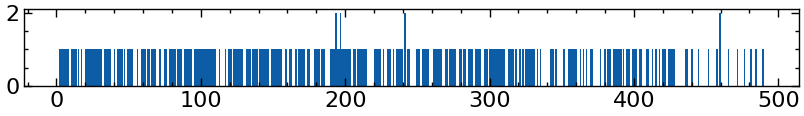

In [235]:
plt.figure(figsize=[10, 1])
plt.hist(result_table['SCRIPT_NUMBER_ID'][mask_spec_simbad], bins=490);

In [236]:
unq, unq_idx, unq_cnt = np.unique(result_table['SCRIPT_NUMBER_ID'], return_inverse=True, return_counts=True)

# result_table['SCRIPT_NUMBER_ID'] #[unq_cnt>1]
len(unq_cnt)

489

### Add the new HSC PDR3 and SIMBAD spec-z into the table

0 = SIMBAD spec-z

1 = PDR3 spec-z

In [238]:
idx = result_table['SCRIPT_NUMBER_ID'].data.data - 1
idx_simbad_specz = idx[mask_spec_simbad]

# prepare the updated table by copying and adding extra columns
data_agn_updated = copy.deepcopy(data_agn)
data_agn_updated['bibcode'] = '-'*19
data_agn_updated['bibcode'][data_agn['r_z']==1] = '2020ApJ...894...24K'
data_agn_updated['bibcode'][data_agn['r_z']==2] = '2018ApJ...858...77H'
data_agn_updated['bibcode'][data_agn['r_z']==3] = '2016ApJ...817...34M'
data_agn_updated['bibcode'][data_agn['r_z']==4] = '2016ApJS..224...24L'
#data_agn_updated['r_z_bak'] = data_agn['r_z']==2

for j,i in enumerate(idx_hsc_specz):
    # Update the table and backup the original data
    data_agn_updated['r_z'][i] = 1
    data_agn_updated['z'][i] = hsc_targets['specz_redshift'][idx_hsc_pdr3[j]]
    data_agn_updated['bibcode'][i] = 'PDR3 miscellaneous' ### TODO Add

for j,i in enumerate(idx_simbad_specz):
    # Update the table and backup the original data
    if data_agn_updated['r_z'][i] > 2:
        data_agn_updated['r_z'][i] = 0
        data_agn_updated['z'][i] = result_table[mask_spec_simbad]['Z_VALUE'][j]
        data_agn_updated['bibcode'][i] = result_table[mask_spec_simbad]['RVZ_BIBCODE'][j]

mask_specz_updated = data_agn_updated['r_z'] < 3
print(len(data_agn_updated[mask_specz_updated]))
mask_specz = data_agn['r_z'] < 3
print(len(data_agn[mask_specz]))

data_agn_updated.write('hsc_agn_updated.txt', format='ascii', overwrite=True)

data_agn_updated

407
337


ID,RAdeg,DEdeg,i-mag,X-flag,g-flag,r-flag,i-flag,z-flag,n-corr,z,r_z,ID-COSMOS2015,bibcode
--,deg,deg,mag,--,--,--,--,--,--,--,--,--,
int64,float64,float64,float64,int64,int64,int64,int64,int64,int64,float64,int64,int64,str19
1,150.74386,2.20245,22.71,1,1,1,1,1,6,1.561,3,594392,2016ApJ...817...34M
2,150.73557,2.19957,20.36,1,1,1,1,1,6,3.503096,1,592797,PDR3 miscellaneous
3,150.73353,2.15646,20.88,1,1,1,1,1,6,0.9769,1,565402,PDR3 miscellaneous
4,150.79702,2.13888,21.01,1,1,1,1,1,6,0.5727,1,552225,PDR3 miscellaneous
5,150.78259,2.19306,20.63,1,1,1,1,1,6,0.5847,1,589540,PDR3 miscellaneous
6,150.72019,2.24803,21.13,1,1,1,1,1,6,0.6633,1,625595,PDR3 miscellaneous
7,150.78838,2.34399,19.82,1,1,1,1,1,6,1.964449,1,689768,PDR3 miscellaneous
8,150.71511,2.48483,19.2,1,1,1,1,1,6,1.995,1,782508,PDR3 miscellaneous


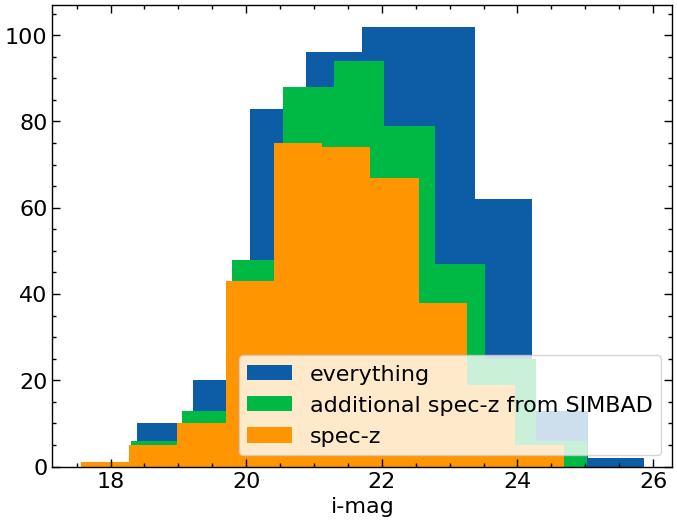

In [239]:
mask_specz_updated = data_agn_updated['r_z'] < 3
plt.hist(data_agn_updated['i-mag'], label='everything')
plt.hist(data_agn_updated['i-mag'][mask_specz_updated], label='additional spec-z from SIMBAD')
mask_specz = data_agn['r_z'] < 3
plt.hist(data_agn['i-mag'][mask_specz], label='spec-z')
plt.xlabel('i-mag')
plt.legend(frameon=True, loc=4)

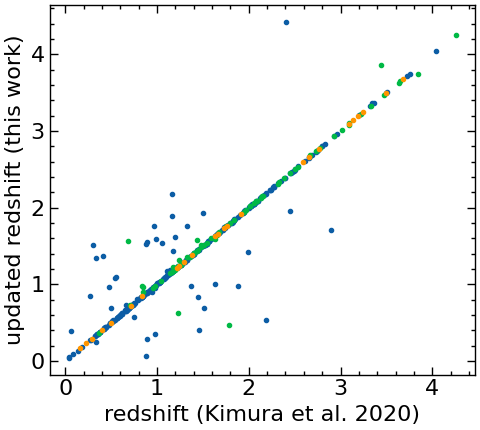

In [240]:
fig, ax = plt.subplots(1,1, figsize=(5, 4.5))

mask_specz = data_agn['r_z'] < 3
ax.scatter(data_agn['z'][mask_specz], data_agn_updated['z'][mask_specz], 
           marker='.', label='spec-z')

mask_specz = (data_agn['r_z'] > 2) & (data_agn_updated['r_z'] < 3)
ax.scatter(data_agn['z'][mask_specz], data_agn_updated['z'][mask_specz],
           marker='.', label='Kimura photo-z -> updated with spec-z')

mask_specz = data_agn_updated['r_z'] > 3
ax.scatter(data_agn['z'][mask_specz], data_agn_updated['z'][mask_specz],
           marker='.', label='photo-z')

ax.set_xlabel('redshift (Kimura et al. 2020)')
ax.set_ylabel('updated redshift (this work)')
# ax.legend()
fig.tight_layout()
fig.savefig('specz.pdf', dpi=300)

Create a bar chart of where our data comes from

In [241]:
# HSC (matched in HSC catalog)
hsc_sources = {}
for key in source_keys: 
    hsc_sources[key] = np.count_nonzero(hsc_targets[idx_hsc_pdr3][key])
hsc_sources_filtered = {key:value for key, value in zip(hsc_sources.keys(), hsc_sources.values()) if value!=0}

# simbad (others than above)
using_simbad_mask = [i not in idx_hsc_specz for i in data_agn_updated['ID']-1]
bibcodes, _ = np.unique(data_agn_updated['bibcode'][using_simbad_mask], return_counts=True)
simbad_sources = {}
for key in bibcodes: 
    simbad_sources[key] = np.count_nonzero(data_agn_updated['bibcode'][using_simbad_mask]==key)

joint_source = {}
joint_source.update(hsc_sources_filtered)
joint_source.update(simbad_sources)
convert_bibcodes = { 
    'specz_flag_zcosmos_bright_dr3':['zCOSMOS DR3 (in HSC)',    'Y', '2009ApJS..184..218L', 'overestimate z'], 
    'specz_flag_3dhst_v4_1_5':      ['3D-HST v4.1.5 (in HSC)',  '?', '2016ApJS..225...27M', ''], 
    'specz_flag_sdss_dr15':         ['SDSS-DR15 (in HSC)',      'Y', '2020ApJS..249....3A', ''], 
    'specz_flag_c3r2_dr2':          ['C3R2 DR2 (in HSC)',       '?', '2017ApJ...841..111M', ''], 
    'specz_flag_vvds_drfinal':      ['VVDS DRFinal (in HSC)',   '?', '2013A&A...559A..14L', ''], 
    'specz_flag_deimos_2018':       ['DEIMOS (in HSC)',         'N', '2018ApJ...858...77H', 'no website'], 
    'specz_flag_fmos_dr2':          ['FMOS-COSMOS DR2 (in HSC)','?', '2015ApJS..220...12S', ''], 
    'specz_flag_lega_c_dr2':        ['LEGA-C DR2 (in HSC)',     '?', '2018ApJS..239...27S', ''], 
    'specz_flag_primus_dr1':        ['PRIMUS (in HSC)',         'N', '2013ApJ...767..118C', 'prism, underestimate z'], 
    '-------------------':          ['not specified',           '?', '-------------------', ''], 
    '2009ApJ...696.1195T':          ['Magellean/zCOSMOS',       'Y', '2009ApJ...696.1195T', ''], 
    '2015ApJS..220...12S':          ['2015ApJS..220...12S',     '?', '2015ApJS..220...12S', ''], 
    '2018ApJ...858...77H':          ['DEIMOS',                  'N', '2018ApJ...858...77H', 'spectra not available'], 
    '2018ApJ...869...20B':          ['2018ApJ...869...20B',     '?', '2018ApJ...869...20B', ''], 
    '2018ApJS..234...21D':          ['2018ApJS..234...21D',     '?', '2018ApJS..234...21D', ''], 
    '2018ApJS..239...27S':          ['2018ApJS..239...27S',     '?', '2018ApJS..239...27S', ''], 
    '2018PASJ...70S..10O':          ['2018PASJ...70S..10O',     '?', '2018PASJ...70S..10O', ''], 
    '2019ApJ...877...81M':          ['2019ApJ...877...81M',     '?', '2019ApJ...877...81M', ''], 
    '2020AJ....160...37M':          ['2020AJ....160...37M',     '?', '2020AJ....160...37M', ''], 
    '2020ApJ...894...24K':          ['Yuki K. (2020)',          'N', '2020ApJ...894...24K', 'HSC QSO catalog we used'], 
    '2021ApJS..256....9S':          ['2021ApJS..256....9S',     '?', '2021ApJS..256....9S', ''], 
    '2016ApJ...817...34M':          ['Chandra (may phot-z)',    '?', '2016ApJ...817...34M', ''], 
    '2016ApJS..224...24L':          ['COSMOS2015 (may phot-z)', '?', '2016ApJS..224...24L', '']}

# make a table
source_table = table.Table([[convert_bibcodes[key][0] for key in joint_source.keys()], 
                            list(joint_source.values()), 
                            [convert_bibcodes[key][1] for key in joint_source.keys()], 
                            [convert_bibcodes[key][2] for key in joint_source.keys()],
                            [convert_bibcodes[key][3] for key in joint_source.keys()], ], 
                           names=('source', 'count', 'availability', 'bibcode', 'comment'))
# TODO: complete this table
source_table

# # make a figure
# fig, ax = plt.subplots(1,1, figsize=(7, 6))
# ax.bar([key for key in joint_source.keys()], joint_source.values())
# for c in ax.containers:
#     ax.bar_label(c)
# plt.xticks(rotation=60, ha='right', rotation_mode='anchor');
# ax.set_ylabel('Number')
# fig.tight_layout()
# fig.savefig('specz_source.pdf', dpi=300); [convert_bibcodes[key] for key in joint_source.keys()]

source,count,availability,bibcode,comment
str24,int64,str1,str19,str23
zCOSMOS DR3 (in HSC),134,Y,2009ApJS..184..218L,overestimate z
3D-HST v4.1.5 (in HSC),14,?,2016ApJS..225...27M,
SDSS-DR15 (in HSC),45,Y,2020ApJS..249....3A,
C3R2 DR2 (in HSC),1,?,2017ApJ...841..111M,
VVDS DRFinal (in HSC),2,?,2013A&A...559A..14L,
DEIMOS (in HSC),78,N,2018ApJ...858...77H,no website
FMOS-COSMOS DR2 (in HSC),35,?,2015ApJS..220...12S,
LEGA-C DR2 (in HSC),6,?,2018ApJS..239...27S,
PRIMUS (in HSC),64,N,2013ApJ...767..118C,"prism, underestimate z"


### Visually inspect the inconsistency

Check if SIMBAD spec-z and paper spec-z are consistent

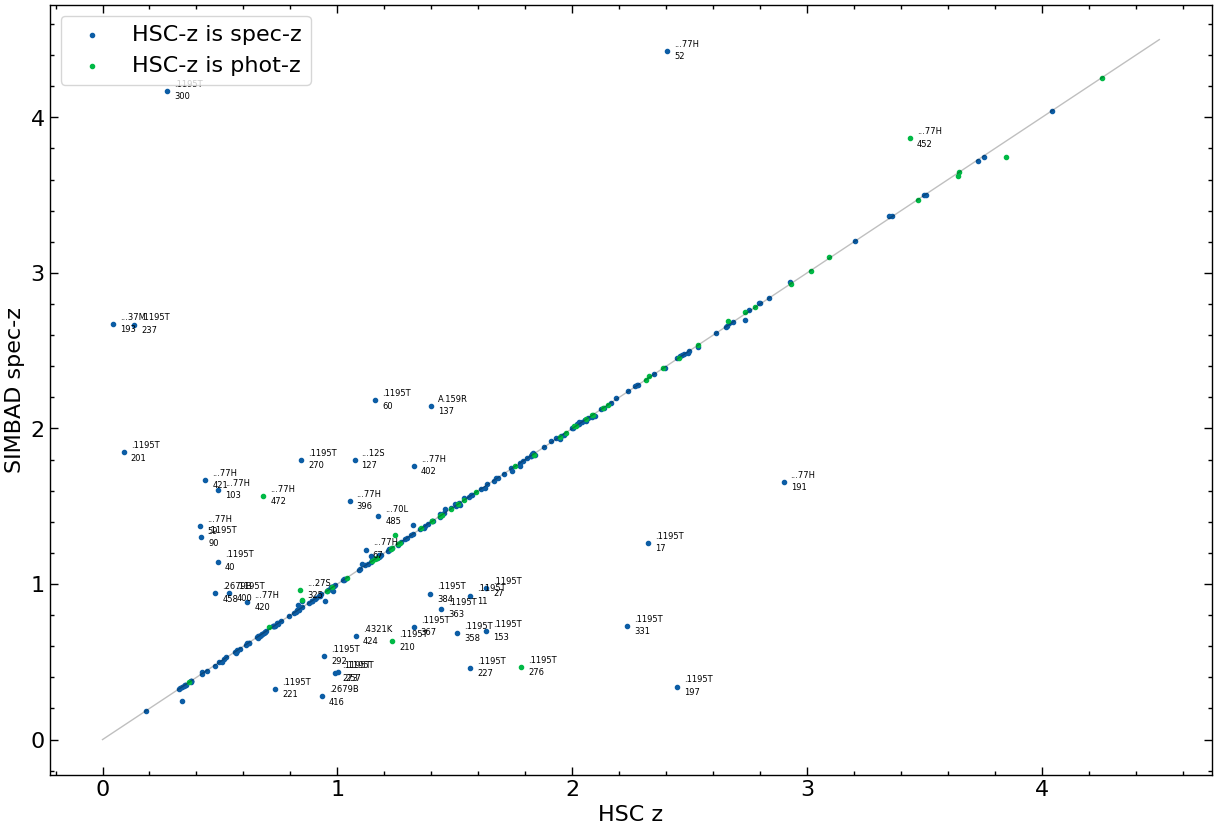

In [242]:
data_agn_compare = table.Table(data=[[0.]*491, ['none']*491, [0.]*491, ['-'*19]*491, [None]*491], 
                               names=['HSC-z', 'r_HSC-z', 'SIMBAD-z', 'bib_SIMBAD-z', 'name'])
for j,i in enumerate(idx_simbad_specz):
    if data_agn['r_z'][i] <= 2:
        data_agn_compare['r_HSC-z'][i] = 'spec'
    else: 
        data_agn_compare['r_HSC-z'][i] = 'phot'
    data_agn_compare['HSC-z'][i] = data_agn['z'][i]
    data_agn_compare['SIMBAD-z'][i] = result_table[mask_spec_simbad]['Z_VALUE'][j]
    data_agn_compare['bib_SIMBAD-z'][i] = result_table[mask_spec_simbad]['RVZ_BIBCODE'][j]
    data_agn_compare['name'][i] = result_table[mask_spec_simbad]['MAIN_ID'][j]

plt.figure(figsize=[15, 10])

plt.scatter(data_agn_compare['HSC-z'][data_agn_compare['r_HSC-z']=='spec'], 
            data_agn_compare['SIMBAD-z'][data_agn_compare['r_HSC-z']=='spec'], 
            marker='.', label='HSC-z is spec-z')
plt.scatter(data_agn_compare['HSC-z'][data_agn_compare['r_HSC-z']=='phot'], 
            data_agn_compare['SIMBAD-z'][data_agn_compare['r_HSC-z']=='phot'], 
            marker='.', label='HSC-z is phot-z')
# add bibcode to interested dots
for i, txt in enumerate(data_agn_compare['bib_SIMBAD-z']): #enumerate(np.arange(491)+1):
    if (np.abs(data_agn_compare['HSC-z'][i] - data_agn_compare['SIMBAD-z'][i])>0.1) : 
        plt.annotate(txt[13:], (data_agn_compare['HSC-z'][i]+0.03, data_agn_compare['SIMBAD-z'][i]+0.03), size=6)
        plt.annotate(i+1, (data_agn_compare['HSC-z'][i]+0.03, data_agn_compare['SIMBAD-z'][i]-0.05), size=6)
plt.plot([0, 4.5], [0, 4.5], '-k', linewidth=1, alpha=0.25)
plt.xlabel('HSC z')
plt.ylabel('SIMBAD spec-z')
plt.legend(frameon=True)
plt.show()

data_agn_compare.write('hsc_agn_compare.txt', format='ascii', overwrite=True)

generate a list of inconsistent values

In [59]:
inconsistent_list = []
for i, txt in enumerate(data_agn_compare['bib_SIMBAD-z']): #enumerate(np.arange(491)+1):
    if abs(data_agn_compare['HSC-z'][i] - data_agn_compare['SIMBAD-z'][i])>0.1 \
       and data_agn_compare['r_HSC-z'][i]=='spec': 
        inconsistent_list.append(i+1)
inconsistent_list = np.array(inconsistent_list)

data_agn_inconsistent = data_agn_updated[inconsistent_list-1]

# for data in data_agn_inconsistent: 
#     print('    OR  abs(specz_ra - %9.5f) < 0.001 AND abs(specz_dec - %7.5f) < 0.001'%(data['RAdeg'], data['DEdeg']))

data_agn_inconsistent 


ID,RAdeg,DEdeg,i-mag,X-flag,g-flag,r-flag,i-flag,z-flag,n-corr,z,r_z,ID-COSMOS2015,bibcode
--,deg,deg,mag,--,--,--,--,--,--,--,--,--,
int64,float64,float64,float64,int64,int64,int64,int64,int64,int64,float64,int64,int64,str19
11,150.66094,1.97536,21.47,1,1,1,1,1,6,1.5652,1,448411,2020ApJ...894...24K
17,150.55903,2.10576,22.61,1,1,1,1,1,6,2.3219,1,529336,2020ApJ...894...24K
27,150.55556,2.36917,23.29,1,1,1,1,1,6,1.634,1,706553,2018ApJ...858...77H
40,150.55588,2.56438,21.89,1,1,1,1,1,6,0.4924,1,834538,2020ApJ...894...24K
52,150.48562,1.87193,22.23,1,1,1,1,1,6,4.426,1,382203,2020ApJ...894...24K
59,150.35262,1.93201,22.77,1,1,1,1,1,6,1.373,1,420196,2020ApJ...894...24K
60,150.43102,1.93527,21.47,1,1,1,1,1,6,2.177,1,422734,2020ApJ...894...24K
67,150.41577,1.9678,22.7,1,1,1,1,1,6,1.121,1,443133,2020ApJ...894...24K


### Check with i-magnitude

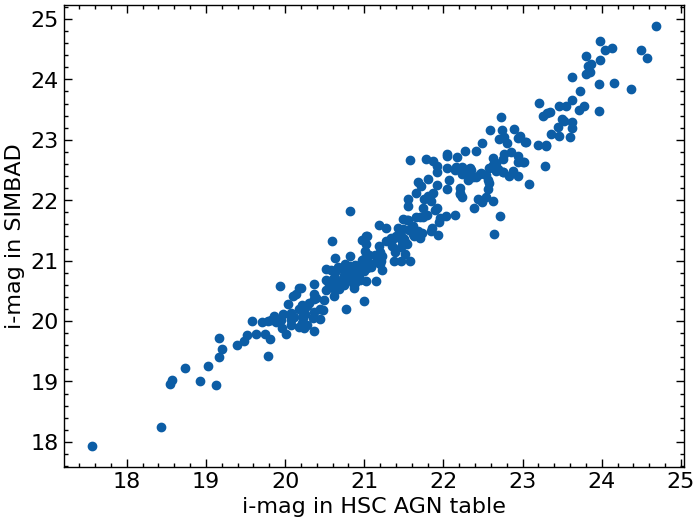

In [256]:
plt.scatter(data_agn['i-mag'][idx_simbad_specz], result_table['FLUX_i'][mask_spec_simbad])
plt.xlabel('i-mag in HSC AGN table')
plt.ylabel('i-mag in SIMBAD');